In [1]:
import pandas as pd
import sklearn
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scipy 
import arcgis

In [2]:
from arcgis.gis import GIS
from arcgis.features import GeoAccessor,GeoSeriesAccessor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

In [3]:
%matplotlib inline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from math import sqrt
from scipy import stats

In [4]:
# read data
gis = GIS()

kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
              'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
              'sqft_lot15']

kc_dtypes = {'id': int, 'date' : str,  'price': float, 'bedrooms' : int, 'bathrooms' : float, 'sqft_living': int, 'sqft_lot': int, 'floors': float, 
             'waterfront': float, 'view' : float, 'condition': float, 'grade': int, 'sqft_above': int, 'yr_built': int,
             'yr_renovated': float, 'zipcode': int, 'lat': float, 'long': float, 'sqft_living15': int, 'sqft_lot15': int}

kc_data = pd.read_csv('dsc-phase-2-project/data/Cleaned_Dataset.csv', parse_dates = ['date'])

In [5]:
#fitting our model by dropping features that dont do much & transforming others into 
#useful data points through multiplying them 
#removing homes with horrible bed to bath ratios 
kc_data['ratio_bd_bth'] = kc_data['bedrooms']/kc_data['bathrooms']
kc_data['sqft_abv_x_living'] = kc_data['sqft_above']*kc_data['sqft_living']
kc_data['sqft_x_grade'] = kc_data['sqft_abv_x_living']*kc_data['grade']
kc_data['sqft_15'] = kc_data['sqft_living15']*kc_data['sqft_lot15']
kc_data['view'].replace({0.19648 : 0 })
kc_data['waterfront'].replace({0.007596 : 0})
 


kc_data = kc_data.loc[kc_data['ratio_bd_bth'] < 3]
kc_data = kc_data.loc[kc_data['floors'] <= 3]
kc_data = kc_data.drop('date', axis=1)#.drop('sqft_above', axis=1).drop('id', axis=1)
#kc_data = kc_data.drop('sqft_living', axis=1).drop('sqft_basement', axis=1)

kc_columns.append(['ratio_bd_bth', 'sqft_abv_and_living', 'sqft_15'])

In [6]:
#filtering by zscore where applicable 
#not applicable: zipcode, yr built(wouldn't want to exclude all recent homes)
# year renovated, basement sqft, view & waterfront (usually 0), floors (only 4, certainly already outlier free)

kc_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
              'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'sqft_15', 'sqft_abv_x_living',
              'ratio_bd_bth', 'sqft_x_grade']
zscore_columns = []

for col in kc_columns:
    col_zscore = str(col + '_zscore')
    kc_data[col_zscore] = (kc_data[col] - kc_data[col].mean())/kc_data[col].std(ddof=0)
    zscore_columns.append(col_zscore)

for column in zscore_columns:
    kc_data = kc_data.loc[kc_data[column] < 2.90]
    kc_data = kc_data.loc[kc_data[column] > (-2.90)]

In [7]:
kc_data['bdscr_n_sqft_lv_scr'] = kc_data['bedrooms']*kc_data['sqft_living']
kc_data['lat_n_long'] = kc_data['lat']*kc_data['long']

#didn't help 
kcy = kc_data[['price']].copy()
kcx = kc_data.drop('price', axis=1)

In [8]:
# initialize regression
reg = linear_model.LinearRegression()
# split data into 80/20 training/testing
x_train, x_test, y_train, y_test = train_test_split(kcx, kcy, test_size=0.2, random_state=42)
# train the model 
reg.fit(x_train, y_train)
# print test data predictions 
y_pred = reg.predict(x_test)

In [9]:
# check accuracy with mean sq 
#np.mean((y_pred - y_test)**2)

In [10]:
#Trying KNN
# maybe try 60% train , 20% adj, 20% test?
cv = KFold(n_splits=10)
classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))
k_pred = cross_val_predict(classifier_pipeline, kcx, kcy, cv=5)

vals = [0.1, 0.2, 0.3, 0.4, 0.5]

for val in vals:
    features = abs(kc_data.corr())['price'][abs(kc_data.corr()['price'])>val].drop('price').index.tolist()
    
    x = kc_data.drop(columns='price')
    x = x[features]
    
    y_pred = cross_val_predict(classifier_pipeline, x, kcy, cv=cv)
    
    print(features)
    print('RMSE:  ' + str(round(sqrt(mean_squared_error(kcy, y_pred)), 2)))
    print('R Squared: ' + str(round(r2_score(kcy, y_pred), 2)))

['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15', 'ratio_bd_bth', 'sqft_abv_x_living', 'sqft_x_grade', 'sqft_15', 'price_zscore', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore', 'sqft_15_zscore', 'sqft_abv_x_living_zscore', 'ratio_bd_bth_zscore', 'sqft_x_grade_zscore', 'bdscr_n_sqft_lv_scr', 'lat_n_long']
RMSE:  63947.3
R Squared: 0.9
['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15', 'sqft_abv_x_living', 'sqft_x_grade', 'sqft_15', 'price_zscore', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore', 'sqft_15_zscore', 'sqft_abv_x_living_zscore', 'sqft_x_grade_zscore', 'bdscr_n_sqft_lv_scr', 'lat_n_long']
RMSE:  61100.47
R Squared: 0.91
['bathrooms', 'sqft_living', 'grade

In [11]:
# Define the problem using features selected above 
outcome = 'price'
# use your columns with lowers RMSE & highest R2 
x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore']

# Fitting the actual model
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     2220.
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        10:55:55   Log-Likelihood:            -2.2125e+05
No. Observations:               16814   AIC:                         4.425e+05
Df Residuals:                   16801   BIC:                         4.426e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.604e+05   5352.702    -86.010      0.000   -4.71e+05    -4.5e+05
bedrooms              -8.53e+05   9888.522    -86.266      0.000   -8.72e+05   -8.34e+05
bathrooms            -7.128e+05   8248.515    -86.415      0.000   -7.29e+05   -6.97e+05
sqft_living          -1484.6735     19.876    -74.697      0.000   -1523.632   -1445.715
floors                -5.39e+05   6346.137    -84.933      0.000   -5.51e+05   -5.27e+05
view                  4.797e+04   1592.980     30.111      0.000    4.48e+04    5.11e+04
grade                 -1.65e+06   1.96e+04    -84.032      0.000   -1.69e+06   -1.61e+06
sqft_above           -1508.4648     18.106    -83.311      0.000   -1543.955   -1472.974
lat                   6.133e+05   7125.021     86.079      0.000    5.99e+05    6.27e+05
sqft_living15        -2294.9075     27.277    -84.135      0.000   -2348.373   -2241.442
sqft_abv_x_living       -0.0472      0.006     -7.300      0.000      -0.060      -0.035
sqft_15                 -0.0004   5.19e-05     -7.193      0.000      -0.000      -0.000
sqft_x_grade             0.0044      0.001      8.484      0.000       0.003       0.005
bedrooms_zscore       7.602e+05   8942.059     85.015      0.000    7.43e+05    7.78e+05
bathrooms_zscore      4.554e+05   5539.389     82.214      0.000    4.45e+05    4.66e+05
sqft_living_zscore    1.241e+06   1.44e+04     86.010      0.000    1.21e+06    1.27e+06
floors_zscore         2.955e+05   3499.022     84.442      0.000    2.89e+05    3.02e+05
grade_zscore          1.784e+06   2.04e+04     87.433      0.000    1.74e+06    1.82e+06
sqft_above_zscore     1.112e+06   1.29e+04     86.010      0.000    1.09e+06    1.14e+06
sqft_living15_zscore  1.461e+06    1.7e+04     86.010      0.000    1.43e+06    1.49e+06
==============================================================================
Omnibus:                     2139.747   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4077.381
Skew:                           0.819   Prob(JB):                         0.00
Kurtosis:                       4.770   Cond. No.                     3.14e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.33e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
# Extract the p-value table from the summary and use it to subset our features
summary = model.summary()

p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)


x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')

print(x_cols[:])
p_table.head()

['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 'lat', 'sqft_living15', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore']


,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,-4.604e+05,5352.702,-86.010,0.0,-4.71e+05,-4.5e+05
bedrooms,-8.53e+05,9888.522,-86.266,0.0,-8.72e+05,-8.34e+05
bathrooms,-7.128e+05,8248.515,-86.415,0.0,-7.29e+05,-6.97e+05
sqft_living,-1484.6735,19.876,-74.697,0.0,-1523.632,-1445.715
floors,-5.39e+05,6346.137,-84.933,0.0,-5.51e+05,-5.27e+05


In [13]:
#investigated multicoliniarity, didn't help, removed non-significant features
#didn't help, went back and filtered everything by z score, no change
# trying 

In [14]:
#kc_data['condition'] = kc_data['condition'].astype(int)
#condition_dummies = pd.get_dummies(kc_data['condition'], prefix='cond', drop_first=True)
#grade_dummies = pd.get_dummies(kc_data['grade'], prefix='grade', drop_first=True)
#bedroom_dummies = pd.get_dummies(kc_data['bedrooms'], prefix='bed', drop_first=True)
#zipcode_dummies = pd.get_dummies(kc_data['zipcode'], drop_first=True)
#kc_data = pd.concat([kc_data], axis=1)

#got dummies, not helpful so far 

In [15]:
#binning my sqft & manually getting dummies 
#kc_data['sndqrt15'] = kc_data['sqft_living15'].between(1460, 1790, inclusive=False) 
#kc_data['trdqrt15'] = kc_data['sqft_living15'].between(1790, 2240, inclusive=False) 
#kc_data['fthqrt15'] = kc_data['sqft_living15'] > 2240
#kc_data['sndqrt15'] = kc_data['sndqrt15'] * 1 
#kc_data['trdqrt15'] = kc_data['trdqrt15'] * 1 
#kc_data['fthqrt15'] = kc_data['fthqrt15'] * 1 

In [16]:
#kc_data = kc_data.drop('sqft_living15', axis=1).drop('sqft_living', axis=1)

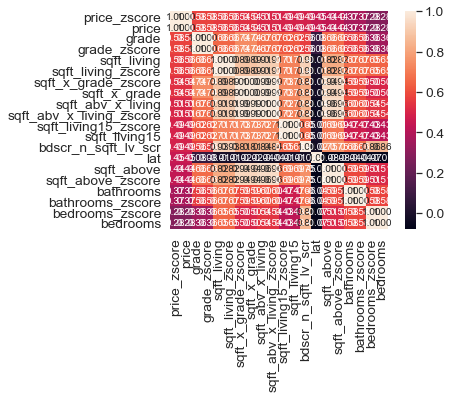

In [17]:
k = 20 #number of variables for heatmap
corrmat = kc_data.corr()
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(kc_data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [18]:

x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'sqft_x_grade', 'ratio_bd_bth', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade', 'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore', 'bdscr_n_sqft_lv_scr', 'lat_n_long']

#for feat in x_cols:
#    kc_data[feat] = kc_data[feat].map(lambda x: np.log(x))

In [19]:
#pd.plotting.scatter_matrix(kc_data, figsize=(10,12));

In [50]:
kc_data = kc_data[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 
                   'sqft_above', 'lat', 'sqft_living15', 'ratio_bd_bth', 'sqft_abv_x_living', 
                   'sqft_15', 'sqft_x_grade']]

In [51]:
# initialize regression
reg = linear_model.LogisticRegression()

In [58]:
# Define the problem using features selected above 
outcome = 'price'
# use your columns with lowers RMSE & highest R2 
# Fitting the actual model

x_cols = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade', 'sqft_above', 
          'lat', 'sqft_living15', 'ratio_bd_bth', 'sqft_abv_x_living', 'sqft_15', 'sqft_x_grade',
          'bedrooms_zscore', 'bathrooms_zscore', 'sqft_living_zscore', 'floors_zscore', 'grade_zscore', 'sqft_above_zscore', 'sqft_living15_zscore']

predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=kc_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     2058.
Date:                Thu, 03 Dec 2020   Prob (F-statistic):               0.00
Time:                        10:47:31   Log-Likelihood:            -2.2123e+05
No. Observations:               16814   AIC:                         4.425e+05
Df Residuals:                   16800   BIC:                         4.426e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -4.605e+05   5346.156    -86.135      0.000   -4.71e+05    -4.5e+05
bedrooms             -8.653e+05   1.01e+04    -86.064      0.000   -8.85e+05   -8.46e+05
bathrooms            -7.004e+05   8457.379    -82.810      0.000   -7.17e+05   -6.84e+05
sqft_living          -1483.4118     19.852    -74.722      0.000   -1522.325   -1444.499
floors               -5.392e+05   6338.390    -85.062      0.000   -5.52e+05   -5.27e+05
view                   4.74e+04   1593.410     29.747      0.000    4.43e+04    5.05e+04
grade                -1.649e+06   1.96e+04    -84.121      0.000   -1.69e+06   -1.61e+06
sqft_above           -1505.7409     18.089    -83.240      0.000   -1541.197   -1470.284
lat                   6.115e+05   7121.795     85.862      0.000    5.98e+05    6.25e+05
sqft_living15        -2294.6141     27.243    -84.227      0.000   -2348.014   -2241.215
ratio_bd_bth          5.982e+04   9194.004      6.506      0.000    4.18e+04    7.78e+04
sqft_abv_x_living       -0.0461      0.006     -7.133      0.000      -0.059      -0.033
sqft_15                 -0.0004   5.19e-05     -7.094      0.000      -0.000      -0.000
sqft_x_grade             0.0041      0.001      7.947      0.000       0.003       0.005
bedrooms_zscore        7.47e+05   9159.240     81.556      0.000    7.29e+05    7.65e+05
bathrooms_zscore       4.75e+05   6300.830     75.392      0.000    4.63e+05    4.87e+05
sqft_living_zscore    1.242e+06   1.44e+04     86.135      0.000    1.21e+06    1.27e+06
floors_zscore         2.955e+05   3494.727     84.551      0.000    2.89e+05    3.02e+05
grade_zscore          1.785e+06   2.04e+04     87.590      0.000    1.74e+06    1.82e+06
sqft_above_zscore     1.112e+06   1.29e+04     86.135      0.000    1.09e+06    1.14e+06
sqft_living15_zscore  1.461e+06    1.7e+04     86.135      0.000    1.43e+06    1.49e+06
==============================================================================
Omnibus:                     2120.154   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4042.265
Skew:                           0.813   Prob(JB):                         0.00
Kurtosis:                       4.768   Cond. No.                     2.59e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.89e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""